#### Libraries used:

In [1]:
import json # json is javascrip obj notation file use for text data bet client server
import pandas as pd # pandas
import requests #http requests
import time  #time related operations
import nltk

from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Download the WordNet and stopwords resources if you haven't already
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mksag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mksag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### 1. Get data from web using requests and saving it in local storage

In [2]:
# headers has a string identified by reddit api to get data
headers = {'User-agent': 'yourbot'} # to request reddits api we need user-agent name``

API request using a function()

In [3]:
def get_data_from_url(url):
    request = requests.get(url, headers = headers) 
    response = request.json() # convert to json
    return response

Some Parameters to store fecthed data from Subreddit

In [4]:
# variables to fetch data from subreddit:
subreddit_tags = ['joy','sadness','fear', 'anger', 'surprise']
listing = 'top'
limit = 100 
timeframe = 'all' 

Fetching Data and Storing into List:

In [5]:
raw_list = [ ] 
for tag in subreddit_tags: 
    base_url = 'https://www.reddit.com/r/{}/{}.json?limit={}&t={}'
    url = base_url.format(tag, listing, limit, timeframe)
    response = get_data_from_url(url) 
    current_time = time.ctime() # retrive current time of request
    # create a dictionary using key:value pair     
    raw_data = {
            'tag':tag, 'response': response} # it has data fetched from subreddit api tags
    raw_list.append(raw_data)

In [6]:
raw_df = pd.DataFrame(raw_list) # dataframe raw_df

In [7]:
raw_df 

,tag,response
0,joy,"{'kind': 'Listing', 'data': {'after': 't3_pxdi..."
1,sadness,"{'kind': 'Listing', 'data': {'after': 't3_6ec8..."
2,fear,"{'kind': 'Listing', 'data': {'after': None, 'd..."
3,anger,"{'kind': 'Listing', 'data': {'after': 't3_vtd1..."
4,surprise,"{'kind': 'Listing', 'data': {'after': None, 'd..."


In [8]:
raw_df.to_json('rawdataset.json')

##### 2. Parsing data

In [9]:
def parse_response(response):
    # parse a single response
    data = response['data']   # Extract data from the response dictionary
    # Extract specific fields from the 'data' dictionary    
    subreddit_tag = data['subreddit_name_prefixed']    
    title = data['title']                               
    url = data['url']                                   
    text = data['selftext']                             

    #Create a dictionary containing the extracted information    
    data = {'subreddit_tag': subreddit_tag,
            'title':title,
            'url':url,
            'text': text,
            'full_json': response 
            }
    
    return data

In [10]:
df = pd.read_json('rawdataset.json')
df

,tag,response
0,joy,"{'kind': 'Listing', 'data': {'after': 't3_pxdi..."
1,sadness,"{'kind': 'Listing', 'data': {'after': 't3_6ec8..."
2,fear,"{'kind': 'Listing', 'data': {'after': None, 'd..."
3,anger,"{'kind': 'Listing', 'data': {'after': 't3_vtd1..."
4,surprise,"{'kind': 'Listing', 'data': {'after': None, 'd..."


Create a test dataset

In [11]:
#create a new DF final_df by extracting specific information from the 'response' column of df.
dataset = [ ]
for response in df['response']:  
    for subreddit_post in response['data']['children']:
        # Calls the 'parse_response' function to extract and parse information from each subreddit post
        data = parse_response(subreddit_post)
        dataset.append(data) 
final_df = pd.DataFrame(dataset)

In [42]:
final_df.sample(3)

,subreddit_tag,title,url,text,full_json
171,r/Sadness,Worst dilemma or feeling,https://www.reddit.com/r/Sadness/comments/my5h...,I am 20 male from India. I have told all of my...,"{'kind': 't3', 'data': {'approved_at_utc': Non..."
137,r/Sadness,A poem to show what people with depression fee...,https://www.reddit.com/r/Sadness/comments/mkzn...,"You see the sun, I see rain\n\nYou're full of ...","{'kind': 't3', 'data': {'approved_at_utc': Non..."
298,r/Anger,I almost just blasted a message on a woman's o...,https://www.reddit.com/r/Anger/comments/kmixpt...,My ex-wife was subjected to sick and evil leve...,"{'kind': 't3', 'data': {'approved_at_utc': Non..."


In [43]:
final_df.to_json('parsed_dataset') #saves df final_df to jason file dec 1 final

In [47]:
df = final_df

Data cleaning and preprocessing:

In [49]:


# Define the cleaning functions
def remove_special_characters(combined):
    if isinstance(combined, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', combined)
    else:
        return combined

def to_lowercase(combined):
    if isinstance(combined, str):
        return combined.lower()
    else:
        return combined

def lemmatize(combined):
    if isinstance(combined, str):
        lemmatizer = WordNetLemmatizer()
        return ' '.join([lemmatizer.lemmatize(word) for word in combined.split()])
    else:
        return combined

def remove_html_tags(combined):
    if isinstance(combined, str):
        return BeautifulSoup(combined, "html.parser").get_text()
    else:
        return combined

def remove_stopwords(combined):
    stop_words = set(stopwords.words('english'))
    if isinstance(combined, str):
        return ' '.join([word for word in combined.split() if word.lower() not in stop_words])
    else:
        return combined

df['combined'] = df['title'] + ' ' + df['text']  

# Apply the cleaning functions to the 'combined' column
df['combined'] = df['combined'].apply(remove_special_characters)
df['combined'] = df['combined'].apply(to_lowercase)
df['combined'] = df['combined'].apply(remove_html_tags)
df['combined'] = df['combined'].apply(lemmatize)
df['combined'] = df['combined'].apply(remove_stopwords)


In [51]:
df['true_labels'] = df['subreddit_tag'].apply(lambda x: x[2:].lower())

In [54]:
reddit_test_dataset = df[['combined', 'true_labels']]

In [56]:
reddit_test_dataset.sample(5)

,combined,true_labels
121,im interested living longer im tired done w ev...,sadness
110,lost sister wa joy big smile used walk like bo...,sadness
128,turn train wreck friend told used charismatic ...,sadness
44,clear quartz health benefit,joy
48,super mario road willie nelson koji kondo nint...,joy


In [ ]:


# Convert the 'combined' column to a list of strings
text_data = df['combined'].tolist()

#### Collecting the laballed dataset

Link for dataset :
https://raw.githubusercontent.com/SannketNikam/Emotion-Detection-in-Text/main/data/emotion_dataset_raw.csv

In [67]:
bert_df = pd.read_csv("labelled_dataset_raw.csv")
bert_df.dropna(inplace=True)
bert_df.columns = bert_df.columns.str.lower() # lower case - column names

In [68]:
bert_df.sample(3)

,emotion,text
28374,sadness,He is portrayed as showing sorrow at the destr...
9360,surprise,Thought I had tests in two of my three classes...
27995,sadness,@Tash_Rat at this point I'm just looking for f...


In [70]:
bert_df['emotion'].value_counts()

emotion
joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: count, dtype: int64

In [73]:
# emotions to be predicted for fine-tuned model
emotions =  ['joy',
            'sadness',
            'anger',
            'fear',
            'surprise'
            ]

bert_df = bert_df[bert_df['emotion'].isin(emotions)] # filter out those emotions
bert_df.reset_index(inplace=True, drop=True) # reset indexes

In [80]:
bert_df['text'] = bert_df['text'].apply(remove_special_characters)
bert_df['text'] = bert_df['text'].apply(to_lowercase)
bert_df['text'] = bert_df['text'].apply(remove_html_tags)
bert_df['text'] = bert_df['text'].apply(lemmatize)
bert_df['text'] = bert_df['text'].apply(remove_stopwords)

In [81]:
lb = LabelEncoder()

In [82]:
bert_df['label'] = lb.fit_transform(bert_df['emotion'])

In [83]:
lb.classes_
label2id = {v:k for k,v in enumerate(lb.classes_)}
id2label = {k:v for k,v in enumerate(lb.classes_)}

In [84]:
label2id, id2label

({'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3, 'surprise': 4},
 {0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness', 4: 'surprise'})

In [85]:
bert_df

,emotion,text,label
0,joy,sage act upgrade list tommorow,2
1,sadness,way homegirl baby funeral man hate funeral rea...,3
2,joy,eye true hazel eyeand brilliant regular featur...,2
3,joy,iluvmiasantos ugh babe hugggzzz u babe naamaze...,2
4,fear,im expecting extremely important phonecall min...,1
...,...,...,...
31531,surprise,michelgw gift hope like hand made wear itll ke...,4
31532,joy,world didnt give meso world definitely cnt tak...,2
31533,anger,man robbed today,0
31534,fear,youu call jealousy call losing,1


<Axes: xlabel='emotion'>

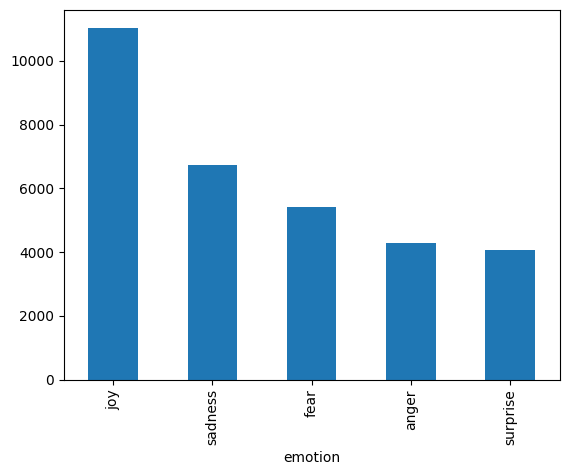

In [86]:
bert_df['emotion'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

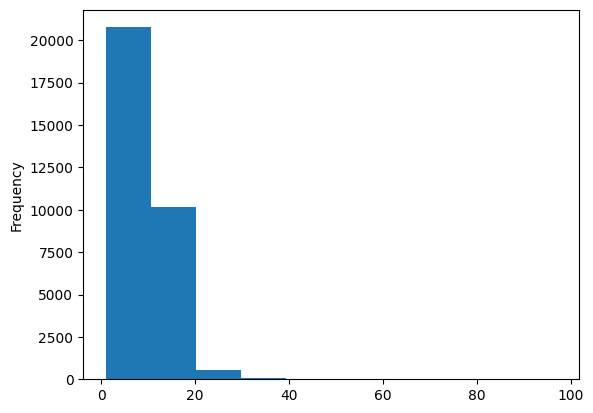

In [87]:
bert_df['text'].apply(lambda x: len(x.split(' '))).plot(kind='hist')

In [90]:
emotion_dataset = bert_df[['text', 'label']]

The above approach takes almost 8 hrs to run 2 epochs. 

### New Approach

In [95]:
def sampling(df):
    new_dfs = []
    for i in range(5):
        sample = df[df['label']==i].sample(200)
        new_dfs.append(sample)
    return pd.concat(new_dfs)

In [96]:
sample_df = sampling(emotion_dataset)

In [103]:
sample_df.shape

(1000, 2)

In [104]:
train, test = train_test_split(sample_df, random_state=1, train_size=0.8, stratify=sample_df['label'])

In [105]:
train.shape, test.shape

((800, 2), (200, 2))

In [106]:
train.label.value_counts(), test.label.value_counts()

(label
 4    160
 0    160
 3    160
 1    160
 2    160
 Name: count, dtype: int64,
 label
 3    40
 0    40
 2    40
 1    40
 4    40
 Name: count, dtype: int64)

In [107]:
train.to_json('emotions_train_sample_dataset.json')

In [102]:
test.to_json("emotions_test_sample_dataset.json")

### The following code is run using Google Collab :

Steps for Model Preparation:

In [ ]:
pip install transformers

In [ ]:
pip install -U accelerate -q

In [ ]:
pip install datasets -q

In [ ]:
pip install evaluate -q

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer

from datasets import Dataset # hugging face dataset
from datasets import load_metric

from sklearn.metrics import accuracy_score


#Step 1 - Dataset Processing


In [ ]:
train = pd.read_json('emotions_train_sample_dataset.json')

test = pd.read_json('emotions_test_sample_dataset.json')

In [ ]:
train.shape , test.shape


((800, 2), (200, 2))

In [ ]:
# convert pandas dataframe object to Hugging Face dataset format
hg_train_data = Dataset.from_pandas(train)
hg_test_data = Dataset.from_pandas(test)

In [ ]:
id2label = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness', 4: 'surprise'}
label2id = {'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3, 'surprise': 4}

#Step 2 - Tokenize Text using Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# tokens config
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

5 special tokens for BERT & each has its associated ID
- [UNK] - unknown tokens
- [SEP] - Seperator
- [PAD] - Padding
- [CLS] - Sentence level classifcation
- [MASK] - Mask token for filling empty slots

- `max_length`
- `padding`
- `truncation`

In [ ]:
# custom function to tokenize our data
def tokenize_text(data):
    max_len = 50 # max len of tokens
    truncation = True
    padding = "max_length" #

    tokens = tokenizer(data['clean_text'],
                       max_length=max_len,
                       truncation=truncation,
                       padding=padding)

    return tokens


In [ ]:
# tokenize our dataset
dataset_train = hg_train_data.map(tokenize_text)
dataset_test = hg_test_data.map(tokenize_text)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['clean_text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 800
})
Dataset({
    features: ['clean_text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


- `__index_level_0__` = index from pandas df
- `input_ids` = max_length (tokens count)
- `token_type_ids` = used for next-sentence prediction tasks, so for our case - values are 0
- `attention_mask` = models will only focus on mask with 1 and ignore 0

Step 3 - Load Pretrained Model & Fine tune

`AutoModelForSequenceClassification` loads BERT model without sequence classification head (no specific output defined), so we have to defined the layer

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           num_labels=5 # 5 class output
                                                           )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- `output_dir` = directory to save model checkpoints and model predictions
- `logging_dir` = directory for saving logs
- `logging_strategy` = log after every epoch
- `num_train_epochs` = no. of training epochs
- `save_strategy` = save after every epoch
- `evaluation_strategy` = evaluate test data after every epoch
- `load_best_model_at_end` = True

In [ ]:
# set training parameters
training_arguments = TrainingArguments(
    output_dir="./TL-emotions/",
    logging_dir="./TL-emotions/logs",
    logging_strategy="epoch",
    num_train_epochs=2,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True
)

In [ ]:
# # custom function for evaluation of model after every epoch
def compute_metrics(eval_pred):
    metric = load_metric('accuracy')
    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.862900,1.160509


TrainOutput(global_step=100, training_loss=0.8628997802734375, metrics={'train_runtime': 509.5722, 'train_samples_per_second': 1.57, 'train_steps_per_second': 0.196, 'total_flos': 20556104880000.0, 'train_loss': 0.8628997802734375, 'epoch': 1.0})

#Step 4 - Make Predictions

In [ ]:
y_test_predict = trainer.predict(dataset_test)

# there are 2 arrays , 1 = predicted logit for each labels , 2 = label_ids = original labels

y_test_logits = y_test_predict.predictions
y_test_logits[:5]


array([[-1.204955  ,  0.35409606, -0.8233636 ,  2.7603614 , -1.2011135 ],
       [-0.7200953 ,  2.8937607 , -1.3308425 ,  0.20559886, -0.818235  ],
       [-1.3855621 ,  0.48065835,  1.6020288 , -0.6394992 , -0.16535473],
       [ 0.25103936, -0.9956364 , -0.68670106, -0.9500042 ,  1.4947903 ],
       [ 0.10728908,  1.5630718 , -0.71503997, -0.22304262, -0.6844692 ]],
      dtype=float32)

In [ ]:
# we have to apply softmax for getting the predcitions of each labels & those would sum up to 1.

y_test_probabilities = tf.nn.softmax(y_test_logits)

y_test_probabilities[:5]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0.01640428, 0.07799098, 0.02402592, 0.8651115 , 0.01646741],
       [0.02376316, 0.8818237 , 0.01290209, 0.05996915, 0.02154183],
       [0.03048946, 0.19707833, 0.60484475, 0.06429255, 0.10329493],
       [0.18353844, 0.05275973, 0.07185741, 0.05522305, 0.63662136],
       [0.14494899, 0.6215179 , 0.0636916 , 0.10417272, 0.06566879]],
      dtype=float32)>

In [ ]:
# to get labels, `np.argmax` is used

y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)

y_test_pred_labels[:5]

array([3, 1, 2, 4, 1])

In [ ]:
# actual labels
y_test_actual_labels = y_test_predict.label_ids

y_test_actual_labels[:5]

array([3, 0, 2, 3, 1])

#Step 5 - Test Model

In [ ]:
accuracy_score( y_test_actual_labels, y_test_pred_labels)

0.565

#Step 6 - Save Model & Load Model

In [ ]:
tokenizer.save_pretrained("./TL-emotions-/")
trainer.save_model("./TL-emotions-/")

In [ ]:
tok = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/TL-emotions-")

mod = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/TL-emotions-",
                                                         id2label=id2label,
                                                         label2id=label2id)

In [ ]:
# pipeline for predictions
text_classification_pipeline = pipeline(
    "text-classification",
    model=mod,
    tokenizer=tok,
    truncation=True,
    function_to_apply="softmax"
)


In [ ]:
text = "dad hopefully buying iphone today"
tok(text)

{'input_ids': [101, 3611, 11504, 9343, 18059, 2651, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
text_classification_pipeline(text)

[{'label': 'joy', 'score': 0.46406659483909607}]

Load Reddit Test DataSet for testing

In [ ]:
df = pd.read_json("reddit_test_dataset.json")

In [ ]:
df['pred_labels'] = df['combined'].apply(lambda x: text_classification_pipeline(x)[0]['label'])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(df['true_labels'], df['pred_labels'])

0.6516290726817042

In [ ]:
df.sample(3)

,true_labels,combined,pred_labels
304,fear,wish took different direction fear sequelsexpa...,fear
114,sadness,cried first time year tonight dont know people...,anger
349,surprise,surprise surprise,surprise


In [ ]:
mod.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
text = "dad hopefully buying iphone today"

In [ ]:
result = text_classification_pipeline(text)